In [9]:
import joblib
x = joblib.load('x')
mask_ratio = joblib.load('mask_ratio')

In [2]:
import torch
N, L, D = x.shape  # batch, length, dim
len_keep = int(L * (1 - mask_ratio))

noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

# sort noise for each sample
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep， large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)

# keep the first subset
ids_keep = ids_shuffle[:, :len_keep]
x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

# generate the binary mask: 0 is keep, 1 is remove
mask = torch.ones([N, L], device=x.device)
mask[:, :len_keep] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_restore)

In [3]:
ids_shuffle


tensor([[105,  48,  18, 113, 142, 163, 110,  77,  41,   2, 117, 139, 192, 123,
          20,  99, 156, 118, 173,  90, 145, 190,  46, 141, 140, 122, 148, 101,
         116,  14,  78, 104, 181, 170,  82, 137, 194,  74,  72, 138, 171,   8,
           0,   3, 188, 114, 193,  45,  61, 151,  42,  47,  63, 143, 174,  39,
          80, 177,  94,   9,  58, 184,  10,  95,  28, 126,  11,  37, 166,  96,
         168, 161, 115, 178,  34,  15,  22, 153,  73, 169, 129, 195,  13,  40,
           7, 182, 146,  76,  17,  71, 135,  19,  86,  24,  55, 136,  21, 167,
          69,  16, 133,  65,  97,   5, 150,  27,  98,  53, 172, 112,  29, 183,
         159,  68, 132, 189, 186, 125,  30,  88, 191,  31, 180,  70, 144, 179,
         127,  57, 106,  35, 100,   6,  87, 109, 165,  51, 157, 124, 130, 121,
         162, 187,  50,  75, 175, 107, 102,   4, 111,  56,  83,   1,  89, 103,
          81,  66,  33, 131,  32,  49,  67, 185,  38,  12, 120,  85,  25, 152,
          60,  59, 134, 149, 154, 119, 128,  36,  44

In [4]:
x.shape, x_masked.shape, mask.shape

(torch.Size([1, 196, 1024]), torch.Size([1, 49, 1024]), torch.Size([1, 196]))

In [5]:
ids_keep.dtype

torch.int64

In [6]:
a = torch.tensor([1, 5, 4, 2, 3])
a[:3], _ = torch.sort(a[:3])
a
# torch.sort(ids_restore[:])

tensor([1, 4, 5, 2, 3])

In [7]:
ids_restore

tensor([[ 42, 151,   9,  43, 147, 103, 131,  84,  41,  59,  62,  66, 163,  82,
          29,  75,  99,  88,   2,  91,  14,  96,  76, 191,  93, 166, 184, 105,
          64, 110, 118, 121, 158, 156,  74, 129, 175,  67, 162,  55,  83,   8,
          50, 179, 176,  47,  22,  51,   1, 159, 142, 135, 193, 107, 177,  94,
         149, 127,  60, 169, 168,  48, 180,  52, 195, 101, 155, 160, 113,  98,
         123,  89,  38,  78,  37, 143,  87,   7,  30, 192,  56, 154,  34, 150,
         194, 165,  92, 132, 119, 152,  19, 185, 186, 181,  58,  63,  69, 102,
         106,  15, 130,  27, 146, 153,  31,   0, 128, 145, 183, 133,   6, 148,
         109,   3,  45,  72,  28,  10,  17, 173, 164, 139,  25,  13, 137, 117,
          65, 126, 174,  80, 138, 157, 114, 100, 170,  90,  95,  35,  39,  11,
          24,  23,   4,  53, 124,  20,  86, 190,  26, 171, 104,  49, 167,  77,
         172, 189,  16, 136, 182, 112, 187,  71, 140,   5, 188, 134,  68,  97,
          70,  79,  33,  40, 108,  18,  54, 144, 178

(448, 448)


/tmp/ipykernel_3767875/3606433267.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


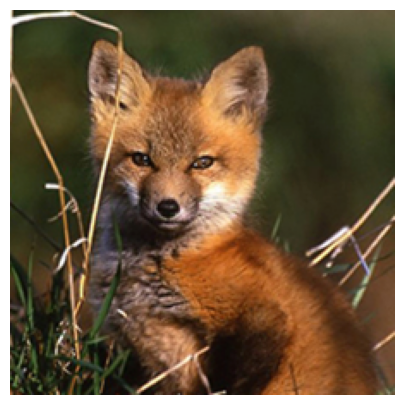

In [18]:
import torch
import numpy as np
from PIL import Image
import requests
import matplotlib.pyplot as plt

import models_mae

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def prepare_mask_and_ids_restore(custom_mask):
    H_patches, W_patches = custom_mask.shape
    L = H_patches * W_patches
    mask = torch.tensor(custom_mask).reshape(1, L)  

    # Get indices of kept and masked patches
    ids_keep = (mask == 1).nonzero(as_tuple=False)[:, 1]
    ids_mask = (mask == 0).nonzero(as_tuple=False)[:, 1]

    # Combine kept and masked indices
    ids_shuffle = torch.cat([ids_keep, ids_mask], dim=0)

    # Generate ids_restore by argsort of ids_shuffle
    ids_restore = torch.argsort(ids_shuffle)

    return mask, ids_restore

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.5)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    
def run_one_image_with_external_mask(img, model, custom_mask):
    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        x = torch.tensor(img).float().to(device)  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        mask, ids_restore = prepare_mask_and_ids_restore(custom_mask)  # mask: [1, 196], ids_restore: [1, 196]
        mask = mask.to(device)
        ids_restore = ids_restore.to(device)
        patches = model.patch_embed(x)  # [1, 196, D]
        x_masked = patches * (1 - mask.unsqueeze(-1))  # [1, 196, D]
        latent, _, _ = model.forward_encoder(x_masked, mask_ratio=0.75, mask=mask, ids_restore=ids_restore)
        pred = model.forward_decoder(latent, ids_restore)  # [1, 196, p*p*3]

        y = model.unpatchify(pred)  # [1, 3, H, W]
        y = torch.einsum('nchw->nhwc', y).detach().cpu()  # [1, H, W, C]

        mask_vis = mask.detach().cpu()
        mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 * 3)  # [1, 196, 768] if patch_size=16 and C=3
        mask_vis = model.unpatchify(mask_vis)  # [1, 3, H, W]
        mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]

        x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
        im_masked = x * (1 - mask_vis)

        im_paste = x * (1 - mask_vis) + y * mask_vis
        plt.rcParams['figure.figsize'] = [24, 24]
        plt.subplot(1, 4, 1)
        show_image(x[0], "Original")
        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "Masked")
        plt.subplot(1, 4, 3)
        show_image(y[0], "Reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "Reconstruction + Visible")

        plt.show() 
    
    
import cv2
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
#将img变为448*448
img = img.resize((448, 448))
cv2.imwrite('fox.jpg', cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))
print(img.size)
# img = Image.open('fox-kandinsky.jpg')
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)


# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [11]:
chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with extra GAN loss:


/tmp/ipykernel_3767875/3085071164.py:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


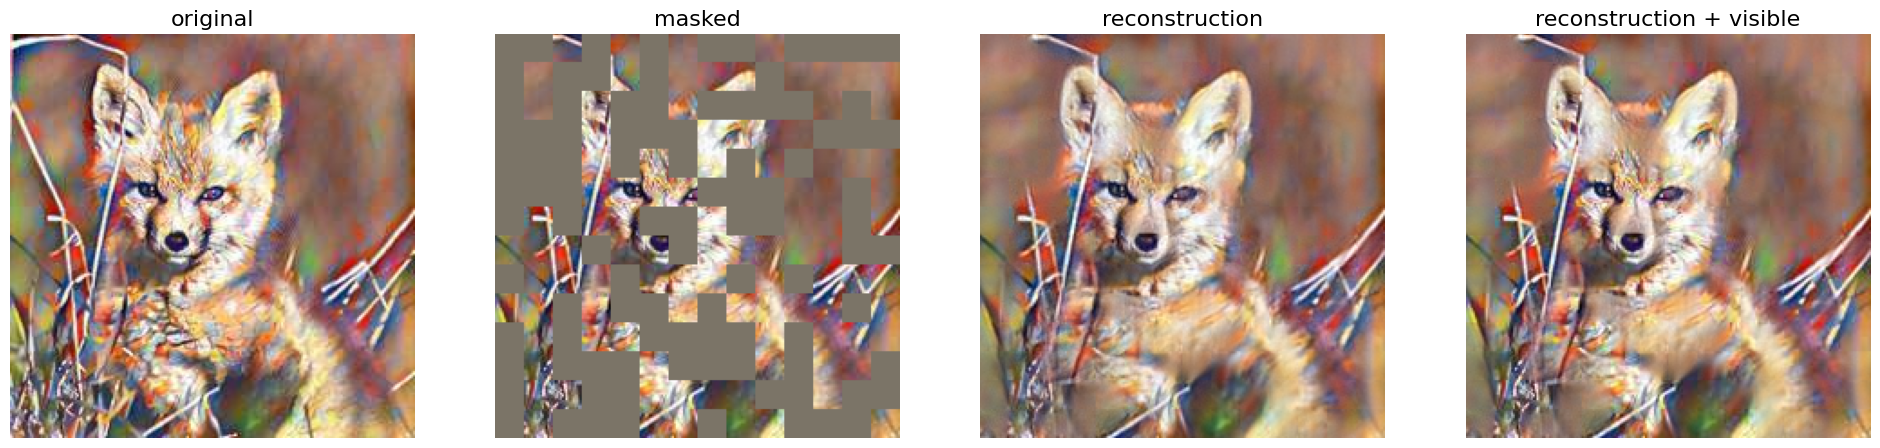

In [12]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(42)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

<All keys matched successfully>
Model loaded.
Before reshape - mask_vis shape: torch.Size([14, 14, 768])
After reshape - mask_vis shape: torch.Size([1, 196, 768])


/tmp/ipykernel_3150990/15706996.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_3150990/15706996.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


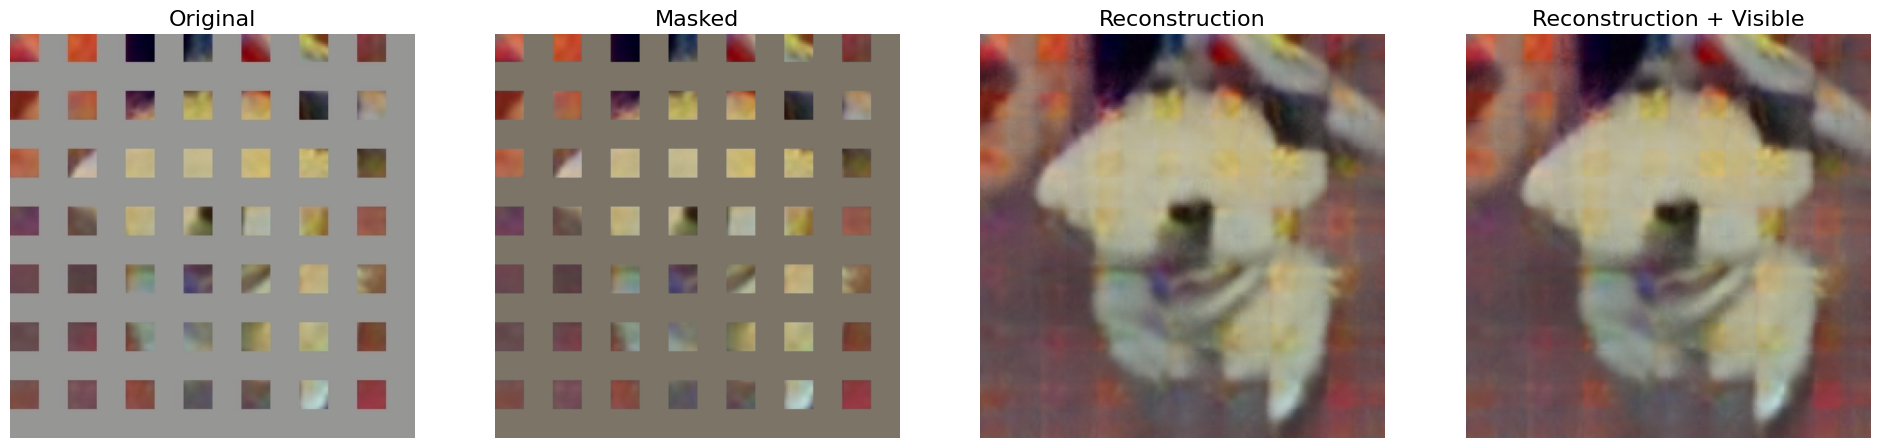

In [65]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def predict(masked_img, mask_matrix,  model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask
    
    
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

original_img = Image.open('results/img2_stitched.jpg').convert('RGB') 
original_img = original_img.resize((224, 224))
original_img_np = np.array(original_img) / 255.0  # [224, 224, 3]
original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std
with open('mask_img1.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
path = 'stitch_transform_masked'
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')
# for image in os.listdir(path):
#     img_path = os.path.join(path, image)
#     masked_img = Image.open(img_path).convert('RGB')
#     masked_img = masked_img.resize((224, 224))
#     masked_img_np = np.array(masked_img) / 255.0
#     masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
#     masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
#     pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
#     y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
#     y = torch.einsum('nchw->nhwc', y).detach().cpu() 
#     show_image(y[0], "Reconstruction")
#     plt.show()
    # patch_size = 16
    # mask_vis = mask.detach().cpu()
    # mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
    # print("Before reshape - mask_vis shape:", mask_vis.shape)

    # mask_vis = mask_vis.reshape(1, 14*14, 768)  

    # print("After reshape - mask_vis shape:", mask_vis.shape)
    # mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
    # mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
    # x = torch.tensor(original_img_normalized).float().to('cuda')
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x).float()
    # x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
    # im_masked = x * (1 - mask_vis)
    # im_paste = x * (1 - mask_vis) + y * mask_vis
    # plt.rcParams['figure.figsize'] = [24, 24]
    # plt.subplot(1, 4, 1)
    # show_image(x[0], "Original")
    # plt.subplot(1, 4, 2)
    # show_image(im_masked[0], "Masked")
    # plt.subplot(1, 4, 3)
    # show_image(y[0], "Reconstruction")
    # plt.subplot(1, 4, 4)
    # show_image(im_paste[0], "Reconstruction + Visible")

    # plt.show()
    

# masked_img = Image.open('mask/masked_img1.jpg').convert('RGB') 
masked_img = Image.open('results/img2_stitched.jpg').convert('RGB') 

masked_img = masked_img.resize((224, 224))
masked_img_np = np.array(masked_img) / 255.0  # [224, 224, 3]
masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std

with open('mask_array/mask_img1.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
y = torch.einsum('nchw->nhwc', y).detach().cpu() 
patch_size = 16
mask_vis = mask.detach().cpu()
mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
print("Before reshape - mask_vis shape:", mask_vis.shape)

mask_vis = mask_vis.reshape(1, 14*14, 768)  

print("After reshape - mask_vis shape:", mask_vis.shape)
mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
x = torch.tensor(original_img_normalized).float().to('cuda')
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x).float()
x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
im_masked = x * (1 - mask_vis)
im_paste = x * (1 - mask_vis) + y * mask_vis
plt.rcParams['figure.figsize'] = [24, 24]
plt.subplot(1, 4, 1)
show_image(x[0], "Original")
plt.subplot(1, 4, 2)
show_image(im_masked[0], "Masked")
plt.subplot(1, 4, 3)
show_image(y[0], "Reconstruction")
plt.subplot(1, 4, 4)
show_image(im_paste[0], "Reconstruction + Visible")

plt.show()

[Info] 已处理并保存: results_75/img070.jpg
[Info] 已处理并保存: results_75/img111.jpg
[Info] 已处理并保存: results_75/img053.jpg
[Info] 已处理并保存: results_75/img025.jpg
[Info] 已处理并保存: results_75/img001.jpg
[Info] 已处理并保存: results_75/img004.jpg
[Info] 已处理并保存: results_75/img013.jpg
[Info] 已处理并保存: results_75/img061.jpg
[Info] 已处理并保存: results_75/img065.jpg
[Info] 已处理并保存: results_75/img075.jpg
[Info] 已处理并保存: results_75/img080.jpg
[Info] 已处理并保存: results_75/img082.jpg
[Info] 已处理并保存: results_75/img005.jpg
[Info] 已处理并保存: results_75/img016.jpg
[Info] 已处理并保存: results_75/img044.jpg
[Info] 已处理并保存: results_75/img014.jpg
[Info] 已处理并保存: results_75/img006.jpg
[Info] 已处理并保存: results_75/img114.jpg
[Info] 已处理并保存: results_75/img102.jpg
[Info] 已处理并保存: results_75/img077.jpg
[Info] 已处理并保存: results_75/img122.jpg
[Info] 已处理并保存: results_75/img015.jpg
[Info] 已处理并保存: results_75/img113.jpg
[Info] 已处理并保存: results_75/img033.jpg
[Info] 已处理并保存: results_75/img010.jpg
[Info] 已处理并保存: results_75/img000.jpg
[Info] 已处理并保存: results_75/img055.jpg
[

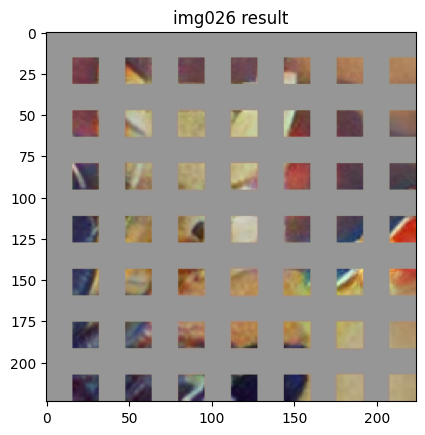

In [2]:
"""
restore stitched img to 224*224
"""
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt

def patchify(img, patch_size=16):
    h,w,c = img.shape
    assert h % patch_size == 0 and w % patch_size == 0
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches

def unpatchify(patches, img_size=(224, 224)):
    """将若干小块拼回原图大小 (224×224)。"""
    h, w = img_size
    img = np.zeros((h, w, 3), dtype=np.uint8)
    idx = 0
    patch_size = patches[0].shape[0]
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            img[i:i+patch_size, j:j+patch_size] = patches[idx]
            idx += 1
    return img

def add2ori(ori, mask, stitch, patch_size=16):
    ori_patches = patchify(ori, patch_size)
    stitch_patches = patchify(stitch, patch_size)
    mask = mask.reshape(1, -1)
    # for idx, val in enumerate(mask[0]):
    #     if val == 0:
    #         ori_patches[idx] = stitch_patches[idx]
    idx_ori = 0
    idx_stitch = 0
    for val in mask[0]:
        if val == 0:
            ori_patches[idx_ori] = stitch_patches[idx_stitch]
            idx_stitch += 1
        idx_ori += 1
    return unpatchify(ori_patches, (224, 224))

# ---------------------
# 以下是批量处理逻辑
# ---------------------

# 1. 准备好文件夹路径

ori_dir = 'mask75_fox'  
stitch_dir = 'stitch_75fox_transfer'
save_dir = 'results_75'
mask_dir = 'mask75_array'
# 2. 如果结果文件夹不存在，自动创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 3. 遍历 mask2_array 中的每个 JSON 文件
for mask_filename in os.listdir(mask_dir):
    if mask_filename.endswith('.json'):
        mask_path = os.path.join(mask_dir, mask_filename)

        # 读取 mask 数据
        with open(mask_path, 'r') as f:
            mask_matrix = np.array(json.load(f))

        # 提取不带扩展名的文件名，用于查找原图和拼接图
        base_filename = os.path.splitext(mask_filename)[0]
        ori_path = os.path.join(ori_dir, base_filename + '.jpg')
        stitch_path = os.path.join(stitch_dir, base_filename + '.jpg')

        # 如果原图或拼接图不存在，则跳过
        if not os.path.exists(ori_path) or not os.path.exists(stitch_path):
            print(f"[Warning] {base_filename} 的原图或拼接图缺失，跳过")
            continue
        
        # 读取 ori 和 stitch 图像
        ori_img = cv2.imread(ori_path)
        stitch_img = cv2.imread(stitch_path)

        if ori_img is None or stitch_img is None:
            print(f"[Error] 无法读取 {ori_path} 或 {stitch_path}，跳过")
            continue
        
        # 4. 调用 add2ori 函数进行图像处理
        new_img = add2ori(ori_img, mask_matrix, stitch_img, patch_size=16)
        
        # 5. 将结果保存到 save_dir 下
        save_path = os.path.join(save_dir, base_filename + '.jpg')
        cv2.imwrite(save_path, new_img)
        
        print(f"[Info] 已处理并保存: {save_path}")
        
        # 可视化结果
        new_img_rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
        plt.imshow(new_img_rgb)
        plt.title(f"{base_filename} result")
        #plt.show()
print("All imgs are complete.")

448 448 3


(np.float64(-0.5), np.float64(447.5), np.float64(447.5), np.float64(-0.5))

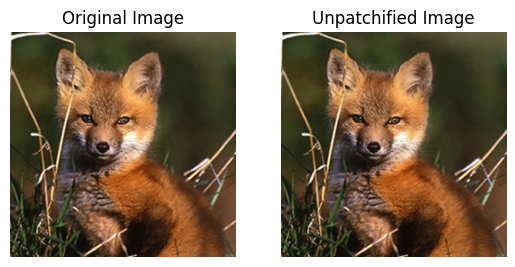

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def patchify(img, patch_size=16):
    h,w,c = img.shape
    print(h,w,c)    
    assert h % patch_size == 0 and w % patch_size == 0
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return patches

def unpatchify(patches, img_size=(224, 224)):
    """将若干小块拼回原图大小 (224×224)。"""
    h, w = img_size
    img = np.zeros((h, w, 3), dtype=np.uint8)
    idx = 0
    patch_size = patches[0].shape[0]
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            img[i:i+patch_size, j:j+patch_size] = patches[idx]
            idx += 1
    return img
img = cv2.imread('fox.jpg')
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
img_patches = unpatchify(patchify(img, patch_size=16),(448,448))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_patches, cv2.COLOR_BGR2RGB))
plt.title('Unpatchified Image')
plt.axis('off')



In [2]:
import numpy as np
import json
mask_path = 'mask_array/mask_img1.json'
with open(mask_path, 'r') as f:
            mask_matrix = np.array(json.load(f))
mask_matrix = mask_matrix.reshape(1, -1)
print(mask_matrix)

[[0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1
  0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
  0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1
  0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [19]:
import json 
import numpy as np
import torch
import cv2
# with open('mask_img1.json', 'r') as f:
#     mask_matrix = np.array(json.load(f))
# # 0 1 2 3 4
# # 0 1 0 1 0

# # 0 2 4 1 3
# # print(mask_matrix)
# mask_matrix = mask_matrix.flatten()
# print(mask_matrix.shape)

# res = []
# for idx,(number) in enumerate(mask_matrix):
#     if number == 0:
#         res.append(idx)
# lenth_keep = len(res)
# # print(lenth_keep)
# for i in range(mask_matrix.shape[0]):
#     if i not in res:
#         res.append(i)
# # print(res)
# idx_shuffle = res
x = cv2.imread('masked_img1.jpg')
x.shape
patch_size = 16


(224, 224, 3)

<All keys matched successfully>
Model loaded.
Before reshape - mask_vis shape: torch.Size([14, 14, 768])
After reshape - mask_vis shape: torch.Size([1, 196, 768])


/tmp/ipykernel_3860112/969097775.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_3860112/969097775.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


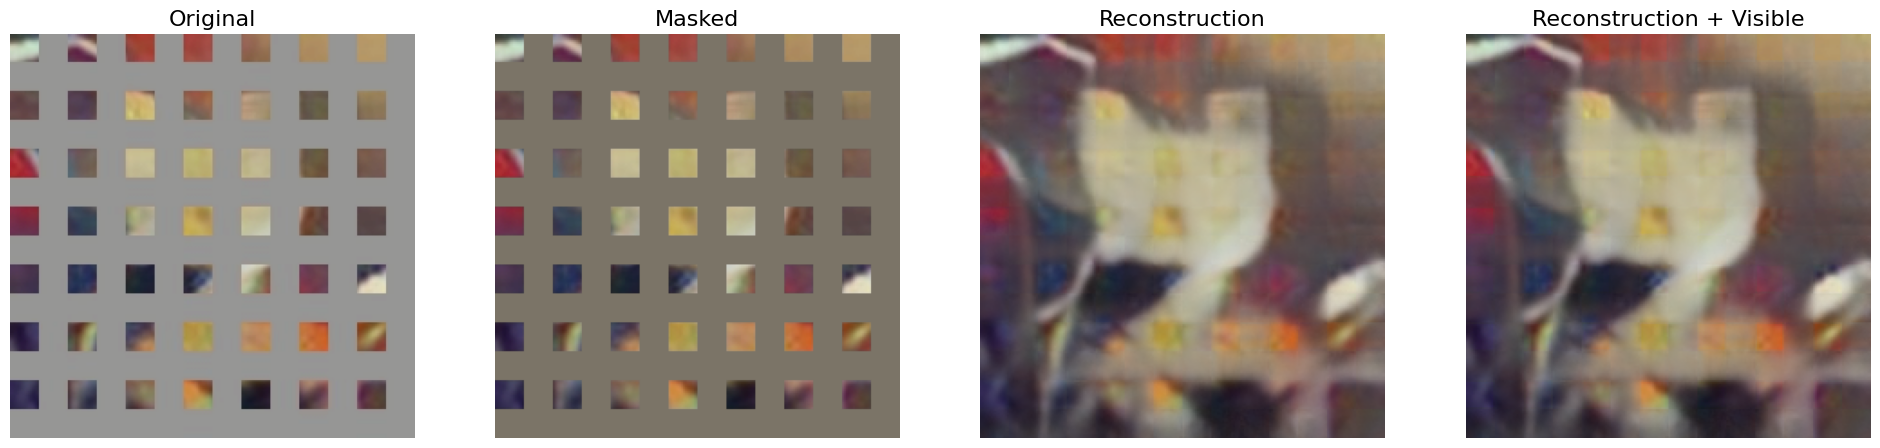

In [16]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def predict(masked_img, mask_matrix,  model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask
    
    
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

original_img = Image.open('results_f/img000.jpg').convert('RGB') 
original_img = original_img.resize((224, 224))
original_img_np = np.array(original_img) / 255.0  # [224, 224, 3]
original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std
with open('mask_f_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
path = 'stitch_f_transform'
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')
# for image in os.listdir(path):
#     img_path = os.path.join(path, image)
#     masked_img = Image.open(img_path).convert('RGB')
#     masked_img = masked_img.resize((224, 224))
#     masked_img_np = np.array(masked_img) / 255.0
#     masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
#     masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
#     pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
#     y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
#     y = torch.einsum('nchw->nhwc', y).detach().cpu() 
#     show_image(y[0], "Reconstruction")
#     plt.show()
    # patch_size = 16
    # mask_vis = mask.detach().cpu()
    # mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
    # print("Before reshape - mask_vis shape:", mask_vis.shape)

    # mask_vis = mask_vis.reshape(1, 14*14, 768)  

    # print("After reshape - mask_vis shape:", mask_vis.shape)
    # mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
    # mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
    # x = torch.tensor(original_img_normalized).float().to('cuda')
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x).float()
    # x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
    # im_masked = x * (1 - mask_vis)
    # im_paste = x * (1 - mask_vis) + y * mask_vis
    # plt.rcParams['figure.figsize'] = [24, 24]
    # plt.subplot(1, 4, 1)
    # show_image(x[0], "Original")
    # plt.subplot(1, 4, 2)
    # show_image(im_masked[0], "Masked")
    # plt.subplot(1, 4, 3)
    # show_image(y[0], "Reconstruction")
    # plt.subplot(1, 4, 4)
    # show_image(im_paste[0], "Reconstruction + Visible")

    # plt.show()
    

# masked_img = Image.open('mask/masked_img1.jpg').convert('RGB') 
masked_img = Image.open('results_f/img000.jpg').convert('RGB') 

masked_img = masked_img.resize((224, 224))
masked_img_np = np.array(masked_img) / 255.0  # [224, 224, 3]
masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std

with open('mask_f_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
y = torch.einsum('nchw->nhwc', y).detach().cpu() 
patch_size = 16
mask_vis = mask.detach().cpu()
mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
print("Before reshape - mask_vis shape:", mask_vis.shape)

mask_vis = mask_vis.reshape(1, 14*14, 768)  

print("After reshape - mask_vis shape:", mask_vis.shape)
mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
x = torch.tensor(original_img_normalized).float().to('cuda')
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x).float()
x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
im_masked = x * (1 - mask_vis)
im_paste = x * (1 - mask_vis) + y * mask_vis
plt.rcParams['figure.figsize'] = [24, 24]
plt.subplot(1, 4, 1)
show_image(x[0], "Original")
plt.subplot(1, 4, 2)
show_image(im_masked[0], "Masked")
plt.subplot(1, 4, 3)
show_image(y[0], "Reconstruction")
plt.subplot(1, 4, 4)
show_image(im_paste[0], "Reconstruction + Visible")

plt.show()

<All keys matched successfully>
Model loaded.
Before reshape - mask_vis shape: torch.Size([14, 14, 768])
After reshape - mask_vis shape: torch.Size([1, 196, 768])


/tmp/ipykernel_3911832/3510002286.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_3911832/3510002286.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


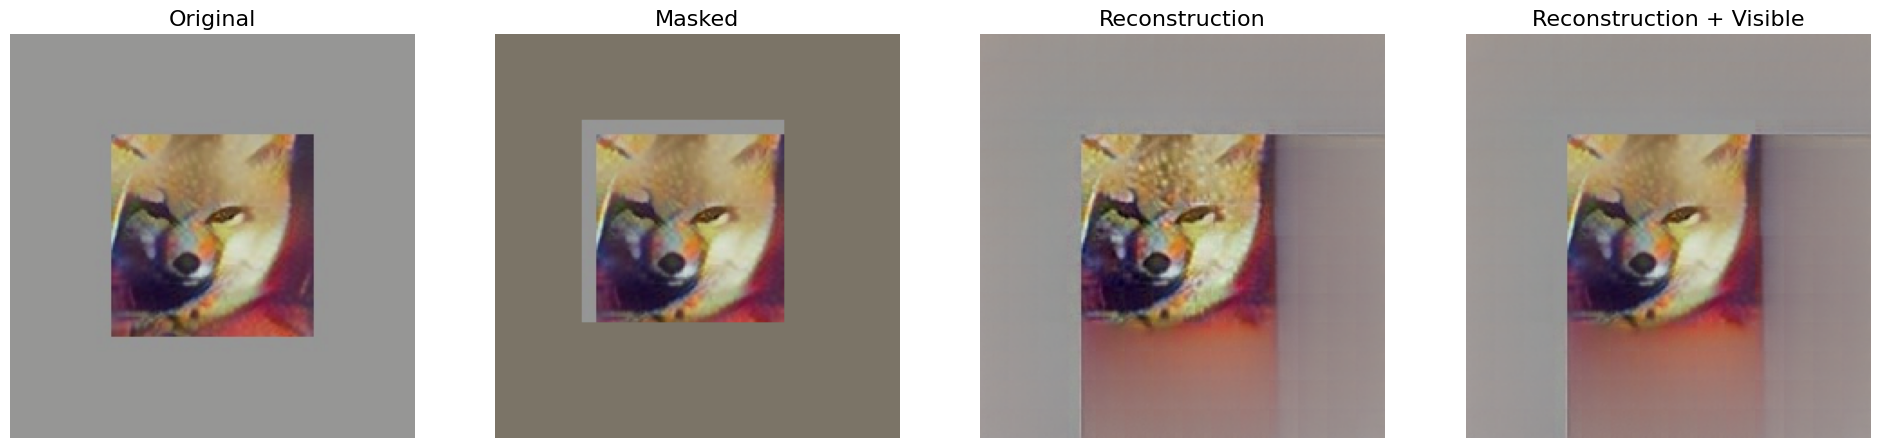

In [2]:
#49 center unmask
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def predict(masked_img, mask_matrix,  model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask
    
    
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

original_img = Image.open('results_fc49/img000.jpg').convert('RGB') 
original_img = original_img.resize((224, 224))
original_img_np = np.array(original_img) / 255.0  # [224, 224, 3]
original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std
with open('mask_fc49_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
path = 'stitch_fc49_transform'
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')
# for image in os.listdir(path):
#     img_path = os.path.join(path, image)
#     masked_img = Image.open(img_path).convert('RGB')
#     masked_img = masked_img.resize((224, 224))
#     masked_img_np = np.array(masked_img) / 255.0
#     masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
#     masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
#     pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
#     y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
#     y = torch.einsum('nchw->nhwc', y).detach().cpu() 
#     show_image(y[0], "Reconstruction")
#     plt.show()
    # patch_size = 16
    # mask_vis = mask.detach().cpu()
    # mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
    # print("Before reshape - mask_vis shape:", mask_vis.shape)

    # mask_vis = mask_vis.reshape(1, 14*14, 768)  

    # print("After reshape - mask_vis shape:", mask_vis.shape)
    # mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
    # mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
    # x = torch.tensor(original_img_normalized).float().to('cuda')
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x).float()
    # x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
    # im_masked = x * (1 - mask_vis)
    # im_paste = x * (1 - mask_vis) + y * mask_vis
    # plt.rcParams['figure.figsize'] = [24, 24]
    # plt.subplot(1, 4, 1)
    # show_image(x[0], "Original")
    # plt.subplot(1, 4, 2)
    # show_image(im_masked[0], "Masked")
    # plt.subplot(1, 4, 3)
    # show_image(y[0], "Reconstruction")
    # plt.subplot(1, 4, 4)
    # show_image(im_paste[0], "Reconstruction + Visible")

    # plt.show()
    

# masked_img = Image.open('mask/masked_img1.jpg').convert('RGB') 
masked_img = Image.open('results_fc49/img000.jpg').convert('RGB') 

masked_img = masked_img.resize((224, 224))
masked_img_np = np.array(masked_img) / 255.0  # [224, 224, 3]
masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std

with open('mask_fc49_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
y = torch.einsum('nchw->nhwc', y).detach().cpu() 
patch_size = 16
mask_vis = mask.detach().cpu()
mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
print("Before reshape - mask_vis shape:", mask_vis.shape)

mask_vis = mask_vis.reshape(1, 14*14, 768)  

print("After reshape - mask_vis shape:", mask_vis.shape)
mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
x = torch.tensor(original_img_normalized).float().to('cuda')
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x).float()
x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
im_masked = x * (1 - mask_vis)
im_paste = x * (1 - mask_vis) + y * mask_vis
plt.rcParams['figure.figsize'] = [24, 24]
plt.subplot(1, 4, 1)
show_image(x[0], "Original")
plt.subplot(1, 4, 2)
show_image(im_masked[0], "Masked")
plt.subplot(1, 4, 3)
show_image(y[0], "Reconstruction")
plt.subplot(1, 4, 4)
show_image(im_paste[0], "Reconstruction + Visible")

plt.show()

<All keys matched successfully>
Model loaded.


/tmp/ipykernel_3917966/1347995684.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_3917966/1347995684.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


Before reshape - mask_vis shape: torch.Size([14, 14, 768])
After reshape - mask_vis shape: torch.Size([1, 196, 768])


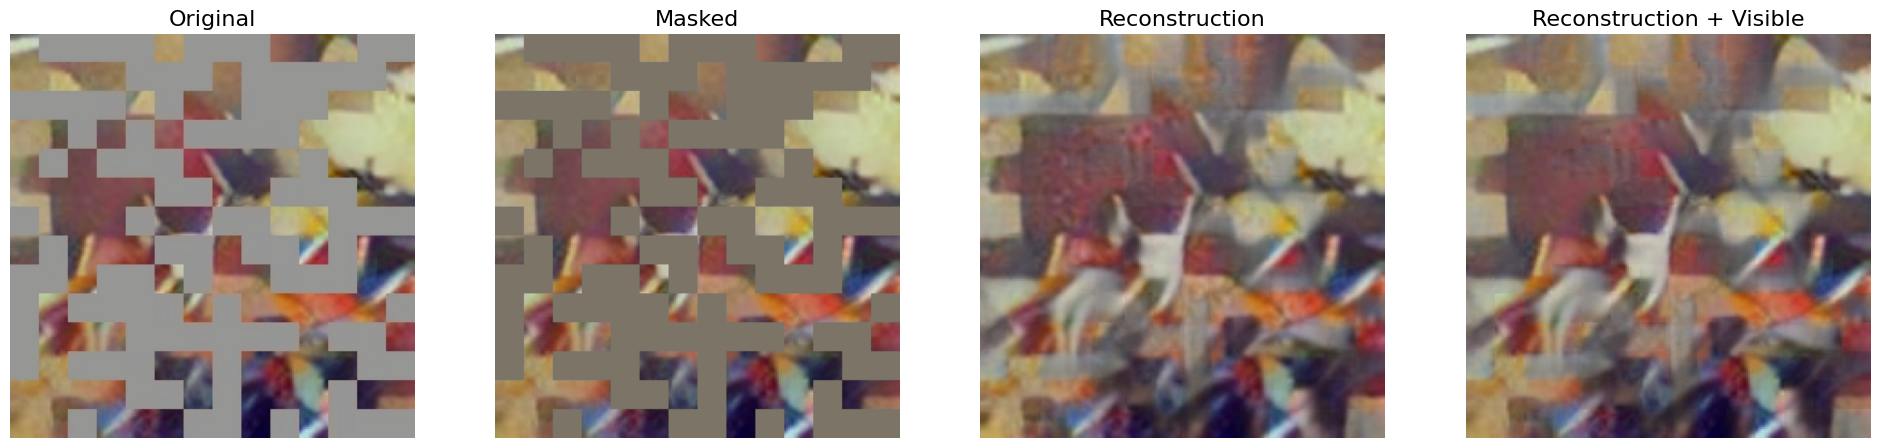

In [1]:
#random 100 mask 
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def predict(masked_img, mask_matrix,  model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask
    
    
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

original_img = Image.open('results_f100/img000.jpg').convert('RGB') 
original_img = original_img.resize((224, 224))
original_img_np = np.array(original_img) / 255.0  # [224, 224, 3]
original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std
with open('mask_f100_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
path = 'stitch_f100_transform'
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')
# for image in os.listdir(path):
#     img_path = os.path.join(path, image)
#     masked_img = Image.open(img_path).convert('RGB')
#     masked_img = masked_img.resize((224, 224))
#     masked_img_np = np.array(masked_img) / 255.0
#     masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
#     masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
#     pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
#     y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
#     y = torch.einsum('nchw->nhwc', y).detach().cpu() 
#     show_image(y[0], "Reconstruction")
#     plt.show()
    # patch_size = 16
    # mask_vis = mask.detach().cpu()
    # mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
    # print("Before reshape - mask_vis shape:", mask_vis.shape)

    # mask_vis = mask_vis.reshape(1, 14*14, 768)  

    # print("After reshape - mask_vis shape:", mask_vis.shape)
    # mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
    # mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
    # x = torch.tensor(original_img_normalized).float().to('cuda')
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x).float()
    # x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
    # im_masked = x * (1 - mask_vis)
    # im_paste = x * (1 - mask_vis) + y * mask_vis
    # plt.rcParams['figure.figsize'] = [24, 24]
    # plt.subplot(1, 4, 1)
    # show_image(x[0], "Original")
    # plt.subplot(1, 4, 2)
    # show_image(im_masked[0], "Masked")
    # plt.subplot(1, 4, 3)
    # show_image(y[0], "Reconstruction")
    # plt.subplot(1, 4, 4)
    # show_image(im_paste[0], "Reconstruction + Visible")

    # plt.show()
    

# masked_img = Image.open('mask/masked_img1.jpg').convert('RGB') 
masked_img = Image.open('results_f100/img000.jpg').convert('RGB') 

masked_img = masked_img.resize((224, 224))
masked_img_np = np.array(masked_img) / 255.0  # [224, 224, 3]
masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std

with open('mask_f100_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
y = torch.einsum('nchw->nhwc', y).detach().cpu() 
patch_size = 16
mask_vis = mask.detach().cpu()
mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
print("Before reshape - mask_vis shape:", mask_vis.shape)

mask_vis = mask_vis.reshape(1, 14*14, 768)  

print("After reshape - mask_vis shape:", mask_vis.shape)
mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
x = torch.tensor(original_img_normalized).float().to('cuda')
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x).float()
x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
im_masked = x * (1 - mask_vis)
im_paste = x * (1 - mask_vis) + y * mask_vis
plt.rcParams['figure.figsize'] = [24, 24]
plt.subplot(1, 4, 1)
show_image(x[0], "Original")
plt.subplot(1, 4, 2)
show_image(im_masked[0], "Masked")
plt.subplot(1, 4, 3)
show_image(y[0], "Reconstruction")
plt.subplot(1, 4, 4)
show_image(im_paste[0], "Reconstruction + Visible")

plt.show()

<All keys matched successfully>
Model loaded.


/tmp/ipykernel_330279/1318833421.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_330279/1318833421.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


Before reshape - mask_vis shape: torch.Size([14, 14, 768])
After reshape - mask_vis shape: torch.Size([1, 196, 768])


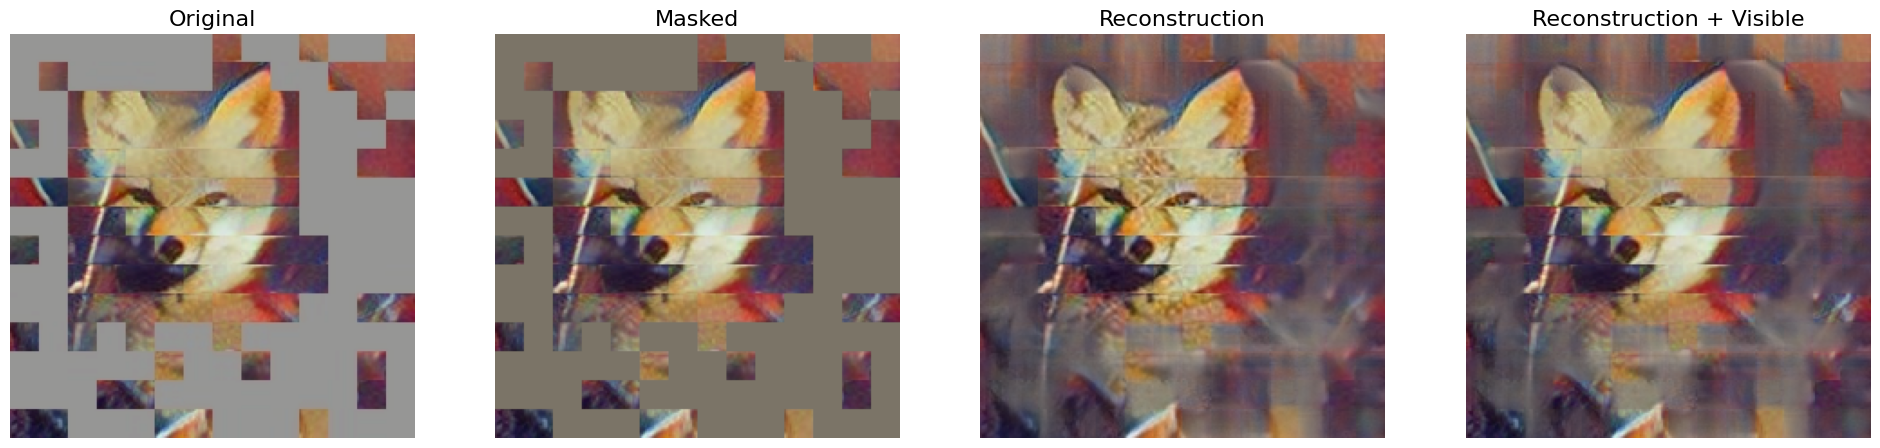

In [2]:
#64 center and 36 random patches unmask
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def predict(masked_img, mask_matrix,  model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask
    
    
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

original_img = Image.open('results_643611/img000.jpg').convert('RGB') 
original_img = original_img.resize((224, 224))
original_img_np = np.array(original_img) / 255.0  # [224, 224, 3]
original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std
with open('mask_6436_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
path = 'stitch_6436_transform'
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')
# for image in os.listdir(path):
#     img_path = os.path.join(path, image)
#     masked_img = Image.open(img_path).convert('RGB')
#     masked_img = masked_img.resize((224, 224))
#     masked_img_np = np.array(masked_img) / 255.0
#     masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
#     masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
#     pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
#     y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
#     y = torch.einsum('nchw->nhwc', y).detach().cpu() 
#     show_image(y[0], "Reconstruction")
#     plt.show()
    # patch_size = 16
    # mask_vis = mask.detach().cpu()
    # mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
    # print("Before reshape - mask_vis shape:", mask_vis.shape)

    # mask_vis = mask_vis.reshape(1, 14*14, 768)  

    # print("After reshape - mask_vis shape:", mask_vis.shape)
    # mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
    # mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
    # x = torch.tensor(original_img_normalized).float().to('cuda')
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x).float()
    # x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
    # im_masked = x * (1 - mask_vis)
    # im_paste = x * (1 - mask_vis) + y * mask_vis
    # plt.rcParams['figure.figsize'] = [24, 24]
    # plt.subplot(1, 4, 1)
    # show_image(x[0], "Original")
    # plt.subplot(1, 4, 2)
    # show_image(im_masked[0], "Masked")
    # plt.subplot(1, 4, 3)
    # show_image(y[0], "Reconstruction")
    # plt.subplot(1, 4, 4)
    # show_image(im_paste[0], "Reconstruction + Visible")

    # plt.show()
    

# masked_img = Image.open('mask/masked_img1.jpg').convert('RGB') 
masked_img = Image.open('results_643611/img000.jpg').convert('RGB') 

masked_img = masked_img.resize((224, 224))
masked_img_np = np.array(masked_img) / 255.0  # [224, 224, 3]
masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std

with open('mask_6436_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
y = torch.einsum('nchw->nhwc', y).detach().cpu() 
patch_size = 16
mask_vis = mask.detach().cpu()
mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
print("Before reshape - mask_vis shape:", mask_vis.shape)

mask_vis = mask_vis.reshape(1, 14*14, 768)  

print("After reshape - mask_vis shape:", mask_vis.shape)
mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
x = torch.tensor(original_img_normalized).float().to('cuda')
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x).float()
x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
im_masked = x * (1 - mask_vis)
im_paste = x * (1 - mask_vis) + y * mask_vis
plt.rcParams['figure.figsize'] = [24, 24]
plt.subplot(1, 4, 1)
show_image(x[0], "Original")
plt.subplot(1, 4, 2)
show_image(im_masked[0], "Masked")
plt.subplot(1, 4, 3)
show_image(y[0], "Reconstruction")
plt.subplot(1, 4, 4)
show_image(im_paste[0], "Reconstruction + Visible")

plt.show()

<All keys matched successfully>
Model loaded.


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed
All imgs are completed
All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

All imgs are completed
All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed
All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in 

All imgs are completed


/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


/tmp/ipykernel_338209/3486994619.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_338209/3486994619.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


All imgs are completed


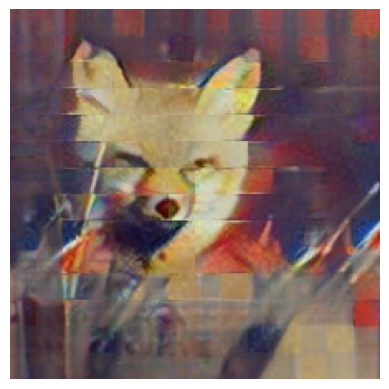

In [1]:
#mask all folder
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def predict(masked_img, mask_matrix, model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

results_fe_path = 'results_fix6436'
results_fe_images = os.listdir(results_fe_path)

mask_fe_array_path = 'mask_fix6436_array'
mask_fe_array_files = os.listdir(mask_fe_array_path)

stitch_fe_transform_path = 'stitch_fix6436_transform'
stitch_fe_transform_images = os.listdir(stitch_fe_transform_path)

mae_foxe_path = 'mae_fix6436'
if not os.path.exists(mae_foxe_path):
    os.makedirs(mae_foxe_path)

for image_name in results_fe_images:
    if image_name.endswith('.jpg'):
        original_img = Image.open(os.path.join(results_fe_path, image_name)).convert('RGB')
        original_img = original_img.resize((224, 224))
        original_img_np = np.array(original_img) / 255.0
        original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std

        mask_file_name = image_name.split('.')[0] + '.json'
        if mask_file_name in mask_fe_array_files:
            with open(os.path.join(mask_fe_array_path, mask_file_name), 'r') as f:
                mask_matrix = np.array(json.load(f))
            mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

            masked_img = Image.open(os.path.join(results_fe_path, image_name)).convert('RGB')
            masked_img = masked_img.resize((224, 224))
            masked_img_np = np.array(masked_img) / 255.0
            masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
            masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')

            pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
            y = model_mae_gan.unpatchify(pred)
            y = torch.einsum('nchw->nhwc', y).detach().cpu()

            patch_size = 16
            mask_vis = mask.detach().cpu()
            mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)
            mask_vis = mask_vis.reshape(1, 14*14, 768)
            mask_vis = model_mae_gan.unpatchify(mask_vis)
            mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()

            x = torch.tensor(original_img_normalized).float().to('cuda')
            x = x.unsqueeze(dim=0)
            x = torch.einsum('nhwc->nchw', x).float()
            x = torch.einsum('nchw->nhwc', x).detach().cpu()
            im_masked = x * (1 - mask_vis)
            im_paste = x * (1 - mask_vis) + y * mask_vis
            
            show_image(im_paste[0])

            plt.savefig(os.path.join(mae_foxe_path, image_name), bbox_inches='tight', pad_inches=0)
            
            saved_image_path = os.path.join(mae_foxe_path, image_name)
            im_paste_resized = Image.open(saved_image_path).resize((448, 448))

            im_paste_resized.save(os.path.join(mae_foxe_path, image_name))

            """
            plt.rcParams['figure.figsize'] = [24, 24]
            plt.subplot(1, 4, 1)
            show_image(x[0], "Original")
            plt.subplot(1, 4, 2)
            show_image(im_masked[0], "Masked")
            plt.subplot(1, 4, 3)
            show_image(y[0], "Reconstruction")
            plt.subplot(1, 4, 4)
            show_image(im_paste[0], "Reconstruction + Visible")
            plt.close()
            """

print("All imgs are completed")

<All keys matched successfully>
Model loaded.


/tmp/ipykernel_330279/2407239924.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_330279/2407239924.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


Before reshape - mask_vis shape: torch.Size([14, 14, 768])
After reshape - mask_vis shape: torch.Size([1, 196, 768])


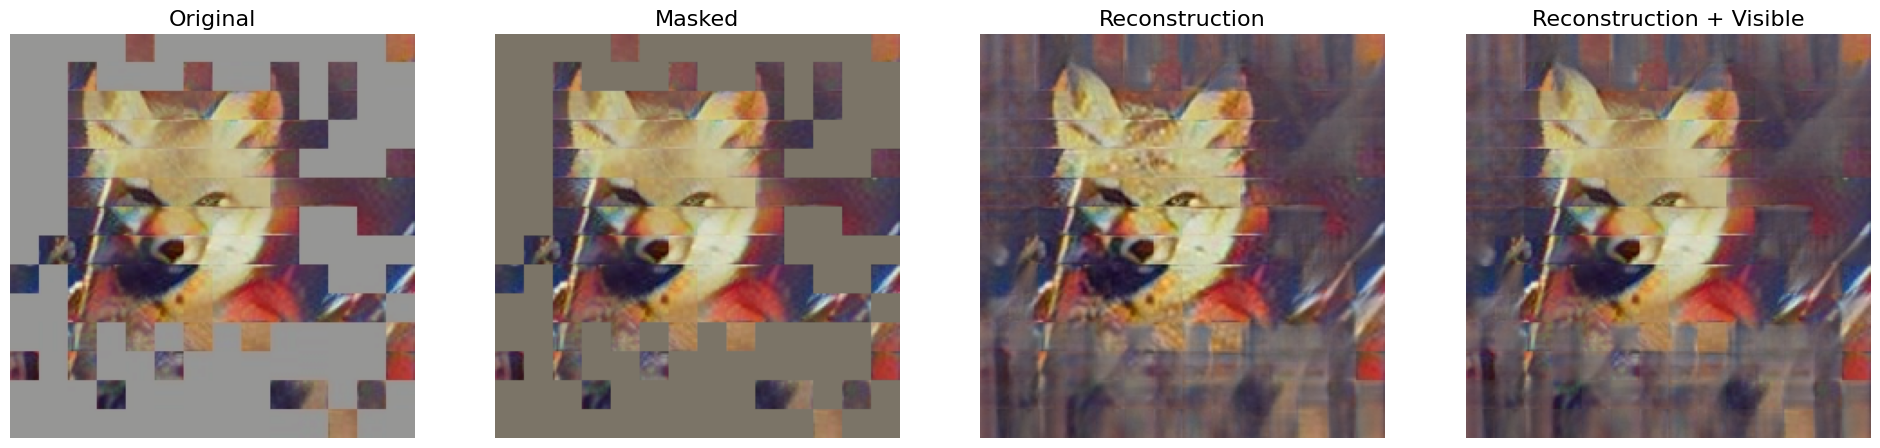

In [8]:
#64 center and 57 random patches unmask
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def predict(masked_img, mask_matrix,  model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask
    
    
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

original_img = Image.open('results_fix6436/img000.jpg').convert('RGB') 
original_img = original_img.resize((224, 224))
original_img_np = np.array(original_img) / 255.0  # [224, 224, 3]
original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std
with open('mask_fix6436_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
path = 'stitch_fix6436_transform'
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')
# for image in os.listdir(path):
#     img_path = os.path.join(path, image)
#     masked_img = Image.open(img_path).convert('RGB')
#     masked_img = masked_img.resize((224, 224))
#     masked_img_np = np.array(masked_img) / 255.0
#     masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
#     masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
#     pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
#     y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
#     y = torch.einsum('nchw->nhwc', y).detach().cpu() 
#     show_image(y[0], "Reconstruction")
#     plt.show()
    # patch_size = 16
    # mask_vis = mask.detach().cpu()
    # mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
    # print("Before reshape - mask_vis shape:", mask_vis.shape)

    # mask_vis = mask_vis.reshape(1, 14*14, 768)  

    # print("After reshape - mask_vis shape:", mask_vis.shape)
    # mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
    # mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
    # x = torch.tensor(original_img_normalized).float().to('cuda')
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x).float()
    # x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
    # im_masked = x * (1 - mask_vis)
    # im_paste = x * (1 - mask_vis) + y * mask_vis
    # plt.rcParams['figure.figsize'] = [24, 24]
    # plt.subplot(1, 4, 1)
    # show_image(x[0], "Original")
    # plt.subplot(1, 4, 2)
    # show_image(im_masked[0], "Masked")
    # plt.subplot(1, 4, 3)
    # show_image(y[0], "Reconstruction")
    # plt.subplot(1, 4, 4)
    # show_image(im_paste[0], "Reconstruction + Visible")

    # plt.show()
    

# masked_img = Image.open('mask/masked_img1.jpg').convert('RGB') 
masked_img = Image.open('results_fix6436/img000.jpg').convert('RGB') 

masked_img = masked_img.resize((224, 224))
masked_img_np = np.array(masked_img) / 255.0  # [224, 224, 3]
masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std

with open('mask_fix6436_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
y = torch.einsum('nchw->nhwc', y).detach().cpu() 
patch_size = 16
mask_vis = mask.detach().cpu()
mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
print("Before reshape - mask_vis shape:", mask_vis.shape)

mask_vis = mask_vis.reshape(1, 14*14, 768)  

print("After reshape - mask_vis shape:", mask_vis.shape)
mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
x = torch.tensor(original_img_normalized).float().to('cuda')
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x).float()
x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
im_masked = x * (1 - mask_vis)
im_paste = x * (1 - mask_vis) + y * mask_vis
plt.rcParams['figure.figsize'] = [24, 24]
plt.subplot(1, 4, 1)
show_image(x[0], "Original")
plt.subplot(1, 4, 2)
show_image(im_masked[0], "Masked")
plt.subplot(1, 4, 3)
show_image(y[0], "Reconstruction")
plt.subplot(1, 4, 4)
show_image(im_paste[0], "Reconstruction + Visible")

plt.show()

<All keys matched successfully>
Model loaded.


/tmp/ipykernel_1231212/2177298482.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
/tmp/ipykernel_1231212/2177298482.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


Before reshape - mask_vis shape: torch.Size([14, 14, 768])
After reshape - mask_vis shape: torch.Size([1, 196, 768])


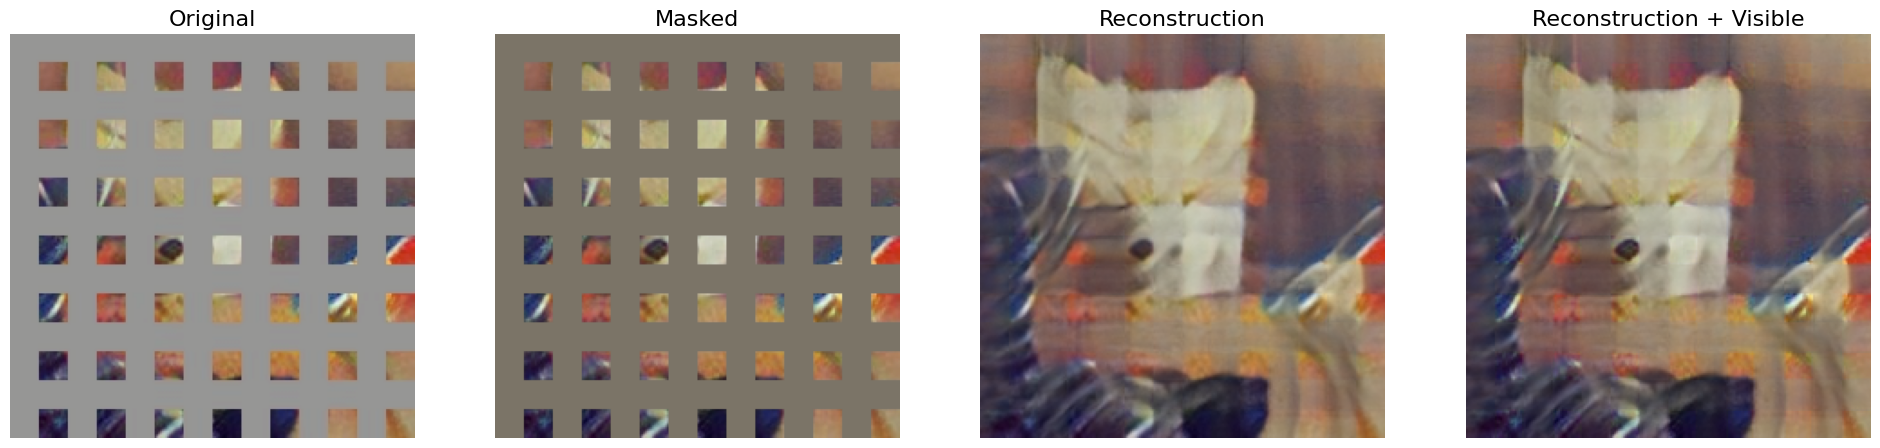

In [3]:
#regular mask
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os
import models_mae

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


def predict(masked_img, mask_matrix,  model, patch_size=16):
    model = model.to('cuda')
    model.eval()
    with torch.no_grad():
        x = torch.tensor(masked_img).float().to('cuda')  # [H, W, C]
        x = x.unsqueeze(dim=0)  # [1, H, W, C]
        x = torch.einsum('nhwc->nchw', x)  # [1, C, H, W]

        loss, pred, mask = model(x, mask_ratio=0.75, mask=mask_matrix)

        return pred, mask
    
    
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

original_img = Image.open('results_75/img000.jpg').convert('RGB') 
original_img = original_img.resize((224, 224))
original_img_np = np.array(original_img) / 255.0  # [224, 224, 3]
original_img_normalized = (original_img_np - imagenet_mean) / imagenet_std
with open('mask75_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
path = 'stitch_75_transfer'
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')
# for image in os.listdir(path):
#     img_path = os.path.join(path, image)
#     masked_img = Image.open(img_path).convert('RGB')
#     masked_img = masked_img.resize((224, 224))
#     masked_img_np = np.array(masked_img) / 255.0
#     masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std
#     masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
#     pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
#     y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
#     y = torch.einsum('nchw->nhwc', y).detach().cpu() 
#     show_image(y[0], "Reconstruction")
#     plt.show()
    # patch_size = 16
    # mask_vis = mask.detach().cpu()
    # mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
    # print("Before reshape - mask_vis shape:", mask_vis.shape)

    # mask_vis = mask_vis.reshape(1, 14*14, 768)  

    # print("After reshape - mask_vis shape:", mask_vis.shape)
    # mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
    # mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
    # x = torch.tensor(original_img_normalized).float().to('cuda')
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x).float()
    # x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
    # im_masked = x * (1 - mask_vis)
    # im_paste = x * (1 - mask_vis) + y * mask_vis
    # plt.rcParams['figure.figsize'] = [24, 24]
    # plt.subplot(1, 4, 1)
    # show_image(x[0], "Original")
    # plt.subplot(1, 4, 2)
    # show_image(im_masked[0], "Masked")
    # plt.subplot(1, 4, 3)
    # show_image(y[0], "Reconstruction")
    # plt.subplot(1, 4, 4)
    # show_image(im_paste[0], "Reconstruction + Visible")

    # plt.show()
    

# masked_img = Image.open('mask/masked_img1.jpg').convert('RGB') 
masked_img = Image.open('results_75/img000.jpg').convert('RGB') 

masked_img = masked_img.resize((224, 224))
masked_img_np = np.array(masked_img) / 255.0  # [224, 224, 3]
masked_img_normalized = (masked_img_np - imagenet_mean) / imagenet_std

with open('mask75_array/img000.json', 'r') as f:
    mask_matrix = np.array(json.load(f)) 
masked_img_normalized = torch.tensor(masked_img_normalized).float().to('cuda')
model_mae_gan = model_mae_gan.to('cuda')
mask_matrix = torch.tensor(mask_matrix).float().to('cuda')

pred, mask = predict(masked_img_normalized, mask_matrix, model_mae_gan, patch_size=16)
y = model_mae_gan.unpatchify(pred)  # [1, 3, H, W]
y = torch.einsum('nchw->nhwc', y).detach().cpu() 
patch_size = 16
mask_vis = mask.detach().cpu()
mask_vis = mask_vis.unsqueeze(-1).repeat(1, 1, patch_size**2 * 3)  # [1, L, p*p*3]
print("Before reshape - mask_vis shape:", mask_vis.shape)

mask_vis = mask_vis.reshape(1, 14*14, 768)  

print("After reshape - mask_vis shape:", mask_vis.shape)
mask_vis = model_mae_gan.unpatchify(mask_vis)  # [1, 3, H, W]
mask_vis = torch.einsum('nchw->nhwc', mask_vis).detach().cpu()  # [1, H, W, C]
x = torch.tensor(original_img_normalized).float().to('cuda')
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x).float()
x = torch.einsum('nchw->nhwc', x).detach().cpu()  # [1, H, W, C]
im_masked = x * (1 - mask_vis)
im_paste = x * (1 - mask_vis) + y * mask_vis
plt.rcParams['figure.figsize'] = [24, 24]
plt.subplot(1, 4, 1)
show_image(x[0], "Original")
plt.subplot(1, 4, 2)
show_image(im_masked[0], "Masked")
plt.subplot(1, 4, 3)
show_image(y[0], "Reconstruction")
plt.subplot(1, 4, 4)
show_image(im_paste[0], "Reconstruction + Visible")

plt.show()